In [1]:
# allows showing the tensorboard widget
%load_ext tensorboard
# reload imports on rerun
%load_ext autoreload

# set to 1 for cuda debugging
%set_env CUDA_LAUNCH_BLOCKING=0

env: CUDA_LAUNCH_BLOCKING=0


In [2]:
# show the tensorboard widget
%tensorboard --logdir lightning_logs

In [3]:
# enable import reloads
%autoreload 2

import pytorch_lightning as lightning

import torch
from torch.utils.data import random_split
from torchvision.datasets.utils import download_and_extract_archive

import numpy as np
import matplotlib.pyplot as plt

import pathlib
from data import MeshDataset, SingleTensorDataset
from point_clouds import PointCloudsModule

In [4]:
plt.rc("figure", dpi=250)
plt.rc("legend", fontsize=6)

plots_path = pathlib.Path("plots")
samples_path = pathlib.Path("samples")

plots_path.mkdir(parents=True, exist_ok=True)
samples_path.mkdir(parents=True, exist_ok=True)

In [5]:
accelerator = "gpu"
devices = 1

In [6]:
torch.autograd.set_grad_enabled(False)

In [7]:
url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
filename = pathlib.Path("ModelNet10.zip")
data_root = pathlib.Path("data")

In [8]:
# download_and_extract_archive(url=url, download_root=str(data_root), extract_root=str(data_root), filename=str(filename))

In [9]:
samples_per_mesh = 2048

In [10]:
train_data = MeshDataset(root=data_root / "processed", split="train", shapes=["chair"], samples=samples_per_mesh)
n_train = int(0.8 * len(train_data))
n_val = len(train_data) - n_train

train_data, val_data = random_split(train_data, [n_train, n_val])

test_data = MeshDataset(root=data_root / "processed", split="test", shapes=["chair"], samples=samples_per_mesh)

len(train_data), len(val_data), len(test_data)

(711, 178, 100)

In [11]:
# normalize within shape, based on train data
# train_chair = train_data[0].unsqueeze(0)
# val_chair = train_data[1].unsqueeze(0)

# mean = torch.mean(train_chair, dim=1)
# std = torch.std(train_chair, dim=1)

# train_chair = (train_chair - mean) / std
# val_chair = (val_chair - mean) / std

# train_data = SingleTensorDataset(train_chair)
# val_data = SingleTensorDataset(val_chair)

# len(train_data), len(val_data), len(test_data)

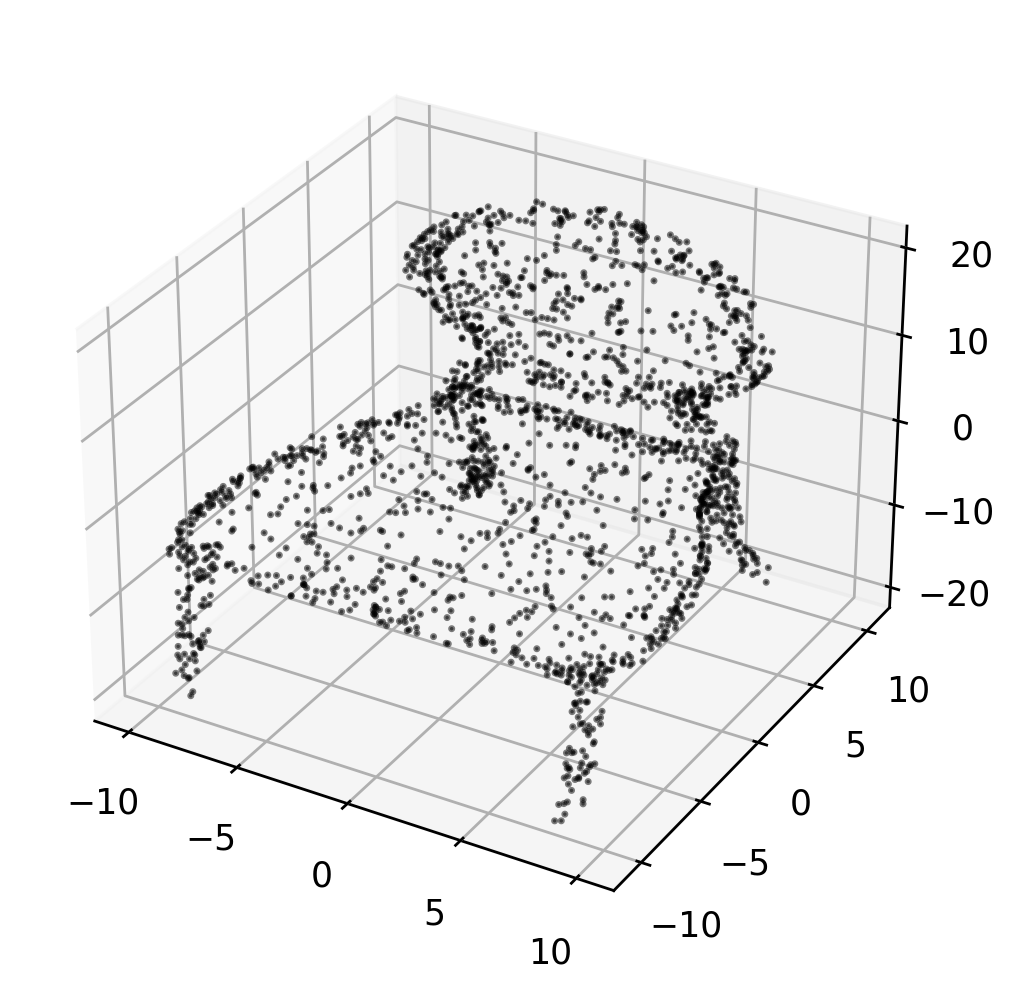

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
points = train_data[0]
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5)
# ax.set_axis_off()
plt.savefig(plots_path / "train_sample.png")

In [13]:
hparams = dict(
    input_dim=3,
    input_points=samples_per_mesh,
    condition_dim=64,
    batch_size=32,
    sample_size=8,
    mmd_samples=None,
    optimizer="adam",
    learning_rate=1e-3,
    weight_decay=1e-5,
    encoder_widths=[[32, 128, 512], [512, 256, 128]],
    rectifier_widths=[64, 128, 128, 64],
    encoder="probabilistic",
    activation="selu",
    pooling="mean",
    integrator="rk45",
    beta=0.34,
    Lambda=0.15,
)

In [14]:
model = PointCloudsModule(train_data, val_data, test_data, **hparams)
print(model)

PointCloudsModule(
  (encoder): Encoder(
    (pre_pool): Sequential(
      (Pre-Pooling Input Layer): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (Pre-Pooling Input Activation): SELU()
      (Pre-Pooling Hidden Layer 0): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (Pre-Pooling Hidden Activation 0): SELU()
      (Pre-Pooling Hidden Layer 1): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (Pre-Pooling Hidden Activation 1): SELU()
      (Pre-Pooling Output Layer): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
    )
    (post_pool): Sequential(
      (Post-Pooling Hidden Layer 0): Linear(in_features=512, out_features=256, bias=True)
      (Post-Pooling Hidden Activation 0): SELU()
      (Post-Pooling Hidden Layer 1): Linear(in_features=256, out_features=128, bias=True)
      (Post-Pooling Hidden Activation 1): SELU()
      (Post-Pooling Output Layer): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (rectifier): NeuralODE(
    (network): Sequential(

In [15]:
model.test_encoder(n_shapes=10)

/home/lars/code/python/point-clouds/point_clouds/model.py:237: UserWarning: Encoder may be misspecified. 633/640 elements close (98.91%). Max deviation: 1.04e-07
  warnings.warn(f"Encoder may be misspecified. {n_close}/{n} elements close ({percentage_close:.2f}%). "


In [ ]:
trainer = lightning.Trainer(
    accelerator=accelerator,
    devices=devices,
    benchmark=True,
    max_epochs=1000,
)

with torch.autograd.enable_grad():
    model.train()
    trainer.fit(model)

# best_model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
# model = best_model

# model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
Missing logger folder: /home/lars/code/python/point-clouds/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | Encoder   | 768 K 
1 | rectifier | NeuralODE | 37.7 K
----------------------------------------
805 K     Trainable params
0         Non-trainable params
805 K     Total params
3.224     Total estimated model params size (MB)
2022-11-24 19:12:23.030005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in othe

Sanity Checking: 0it [00:00, ?it/s]

/home/lars/miniconda3/envs/point-clouds/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
samples = model.sample(n_shapes=9, n_points=1024, steps=100)
np.save(samples_path / "random_samples.npy", samples.numpy())

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "random_samples.png")

In [ ]:
%matplotlib widget
sample = model.sample(n_shapes=1, n_points=4096, steps=1000).squeeze()
np.save(samples_path / "sample.npy", sample.numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=1, color="black", alpha=0.5, lw=0)
plt.show()

In [ ]:
# sample multiple conditions with same latent representation, then interpolate (should deform shape, keeping points roughly same)
# or sample multiple latent variables with same condition, then interpolate (should move points along shape)

In [ ]:
samples = model.sample_shapes(n_shapes=9, n_points=1024, steps=100)

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "shapes.png")

In [ ]:
samples = model.sample_variations(n_shapes=9, n_points=1024, steps=100)

cols = int(np.sqrt(samples.shape[0]))
rows = int(np.ceil(samples.shape[0] / cols))

fig = plt.figure(figsize=plt.figaspect(cols / rows))

for i, points in enumerate(samples):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, color="black", alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig(plots_path / "variations.png")

In [ ]:
plt.ioff()
rows = 100
cols = 6
width = cols
height = rows
fig = plt.figure(figsize=(width, height))
for i, batch in enumerate(model.train_data):
    ax = fig.add_subplot(rows, cols, i + 1, projection="3d")
    ax.scatter(batch[:, 0], batch[:, 1], batch[:, 2], color="black", alpha=0.5, s=1, lw=0)
    ax.set_axis_off()
    
    if i == rows * cols - 1:
        break

# set the spacing between subplots
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
plt.show()

In [ ]:
# if shapes are all the same: check variance of encoder